# 얼굴에 고양이 수염 붙이기!

### 필요 라이브러리 호출

In [241]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib
from PIL import Image
import math
import time

# 카메라앱 기능구현

### 이미지 불러오기

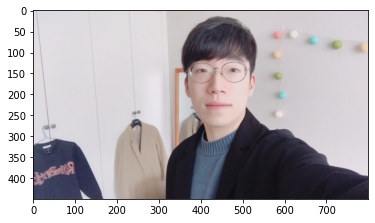

In [242]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.png'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
img_show = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)  #BRG 에서 RGB로 바꿀때

plt.imshow(img_rgb)
plt.show()

### 얼굴 검출하기

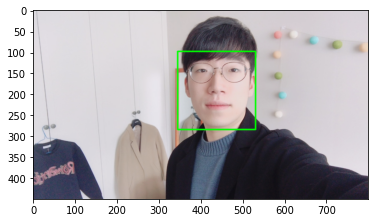

In [244]:
# detector를 선언
detector_hog = dlib.get_frontal_face_detector()

# 사진 변수를 파라미터로 넣어주어야 하는곳
dlib_rects = detector_hog(img_rgb, 1)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    # 사진 변수를 파라미터로 넣어주어야 하는곳
    cv2.rectangle(img_rgb, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

plt.imshow(img_rgb)
plt.show()

### 얼굴 landmark 선택하기

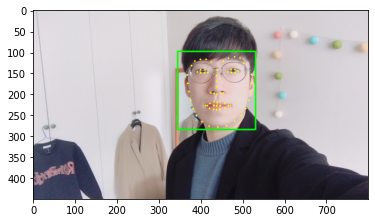

In [245]:
# 저장한 모델 불러오기
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)
    
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_rgb, point, 2, (255, 255, 0, 5), -1)

plt.imshow(img_rgb)
plt.show()

### 코 중심 좌표확인하기

In [246]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[33]) # 코끝 index는 33 입니다
    x = landmark[33][0]
    y = landmark[33][1]
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(439, 200)
(x,y) : (439,200)
(w,h) : (187,187)


<img src="https://www.researchgate.net/profile/Pavel-Korshunov/publication/329392737/figure/fig2/AS:731613625335813@1551441689799/The-68-landmarks-detected-by-dlib-library-This-image-was-created-by-Brandon-Amos-of-CMU.ppm"></img>

### 스티커 불러오기

(187, 187, 3)


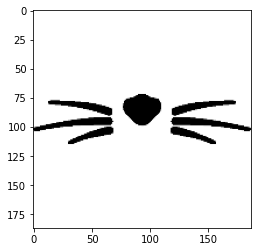

In [247]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h)) # 얼굴 크기에 맞게 스티커를 resize한다.

print (img_sticker.shape)
plt.imshow(img_sticker)
plt.show()

### 스티커 시작좌표 설정

In [248]:
refined_x = x - w // 2
refined_y = y - h // 2 
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (346,107)


### 음수 예외 처리

In [249]:
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

### 스티커 적용하기

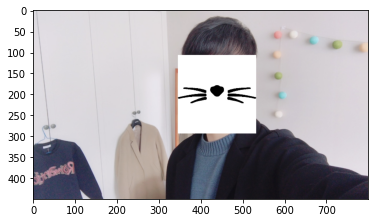

In [252]:
# 길어서 복잡해 보이지만 img_show[from:to] 형식입니다
img_show_test = img_show.copy()

# img_show_test : 원본 사진 카피
# img_sticker : 스티커 사진
# sticker_area : 원본 사진에서 스티커를 스티커 붙일곳 크롭

sticker_area = img_show_test[refined_y:refined_y + img_sticker.shape[0], 
                        refined_x:refined_x + img_sticker.shape[1]]

# img_sticker를 보면서 값이 0(검은색) 이면, img_sticker로 변경, 그외 값은 sticker_area이미지로 변경
img_show_test[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
        np.where(img_sticker==0, sticker_area, img_sticker).astype(np.uint8)

plt.imshow(img_show_test)
plt.show()

## 이미지가 검은색과 흰색이 반전이 되어있다?
왜 그럴까~?  
where(조건, 조건이 true일때의 값, false일때의 값)  
따라서 where 함수를 다시 보면 스티커 이미지의 값이 0일때(검은색) sticker_area(원본 사진 크롭한 부분)으로, 그외 값들은 img_sticker(스티커) 부분을 사용한다  
스티커의 빈공간은 255이고, 고양이 수염은 0의 값을 가지고 있다.  
우리는 검은색 부분을 써야하니, 조건의 값을 255로 설정하거나, 두 매개 변수의 위치를 바꿔주면 된다.

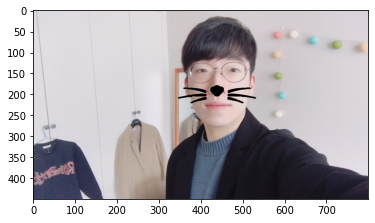

In [253]:
# 길어서 복잡해 보이지만 img_show[from:to] 형식입니다
# img_show_test : 원본 사진 카피
# img_sticker : 스티커 사진
# sticker_area : 원본 사진에서 스티커를 스티커 붙일곳 크롭

sticker_area = img_show[refined_y:refined_y + img_sticker.shape[0], 
                        refined_x:refined_x + img_sticker.shape[1]]

# img_sticker를 보면서 값이 0(검은색) 이면, img_sticker로 변경, 그외 값은 sticker_area이미지로 변경
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
        np.where(img_sticker==255, sticker_area, img_sticker).astype(np.uint8)

plt.imshow(img_show)
plt.show()

### 자연스러운 스티커 적용하기

In [271]:
sticker_area = img_bgr[refined_y:refined_y + img_sticker.shape[0],
                       refined_x:refined_x + img_sticker.shape[1]]
img_bgr[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x + img_sticker.shape[1]] = \
                    cv2.addWeighted(sticker_area, 0.8, np.where(img_sticker==255, sticker_area, img_sticker).astype(np.uint8), 0.2, 0)

cv2.addWeighted(image1, weight1, image2, weight2) 함수  
image1과 image2를 합성하는데, image1은 weight1 만큼 가중치를, image2는 weight2 만큼 가중치를 주어서 합성을 한다.  
따라서 코의 스티커를 흐리게해서 자연스럽게 스티커를 적용한다.

### 최종결과

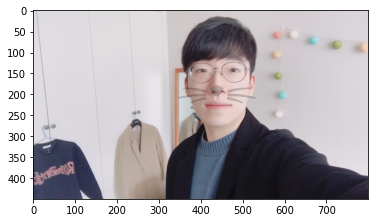

In [272]:
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

# 문제점 분석 및 해결

### 얼굴 사진이 정방향이 아닐때나, 사진의 크기가 작은경우 모델이 작동을 안한다.

In [259]:
image_path = os.getenv('HOME') + '/aiffel/camera_sticker/images/image.png'
img_bgr = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# 저장한 모델 불러오기
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)


In [260]:
img = img_rgb.copy()
img90 = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
img180 = cv2.rotate(img, cv2.ROTATE_180)
img270 = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
img_resize = cv2.resize(img, (80, 45))

In [261]:
image = img_rgb.copy()

def landmarker(image):
    # detector를 선언
    detector_hog = dlib.get_frontal_face_detector()

    # 사진 변수를 파라미터로 넣어주어야 하는곳
    dlib_rects = detector_hog(image, 1)

    list_landmarks = []

    # 얼굴 영역 박스 마다 face landmark를 찾아냅니다
    for dlib_rect in dlib_rects:
        points = landmark_predictor(image, dlib_rect)
        # face landmark 좌표를 저장해둡니다
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks.append(list_points)

    for landmark in list_landmarks:
        for point in landmark:
            cv2.circle(image, point, 5, (255, 0, 0, 5), -1)

    return image

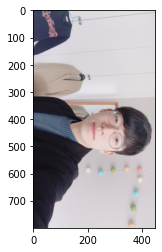

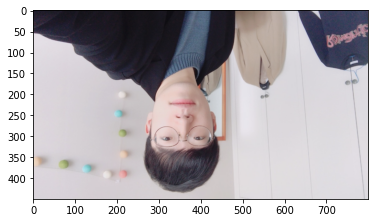

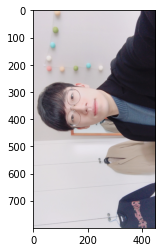

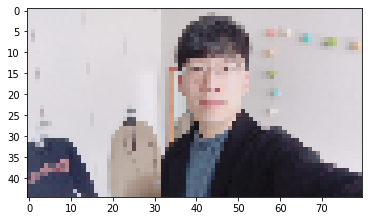

In [262]:
plt.imshow(landmarker(img90))
plt.show()
plt.imshow(landmarker(img180))
plt.show()
plt.imshow(landmarker(img270))
plt.show()
plt.imshow(landmarker(img_resize))
plt.show()

### 사진을 90도씩 3번 돌려봐서, 랜드마크가 찍히면 그 값을 리턴한다.

In [263]:
def rotate_landmarker_test(image):
    # detector를 선언
    detector_hog = dlib.get_frontal_face_detector()

    # 사진 변수를 파라미터로 넣어주어야 하는곳
    dlib_rects = detector_hog(image, 1)

    list_landmarks = []

    # 얼굴 영역 박스 마다 face landmark를 찾아냅니다
    for i in range(0,4):
        for dlib_rect in dlib_rects:           
            points = landmark_predictor(image, dlib_rect)
            # face landmark 좌표를 저장해둡니다
            list_points = list(map(lambda p: (p.x, p.y), points.parts()))
            list_landmarks.append(list_points)

        if len(list_landmarks) != 0:
            break
            
        image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
        dlib_rects = detector_hog(image, 1)
    
    if len(list_landmarks) == 0:
        return None
    
    for landmark in list_landmarks:
        for point in landmark:
            cv2.circle(image, point, 2, (255, 255, 0, 5))

    return image

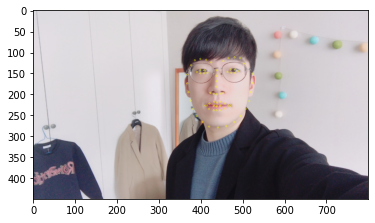

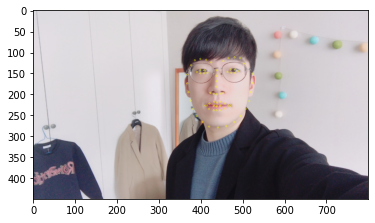

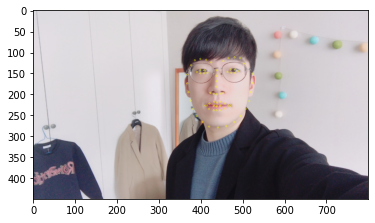

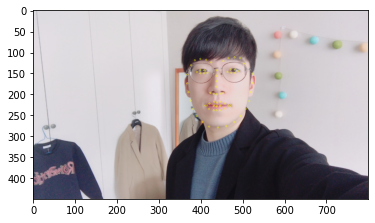

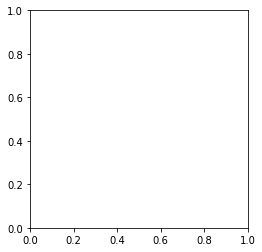

In [264]:
try:
    plt.imshow(rotate_landmarker_test(img))
    plt.show()
    plt.imshow(rotate_landmarker_test(img90))
    plt.show()
    plt.imshow(rotate_landmarker_test(img180))
    plt.show()
    plt.imshow(rotate_landmarker_test(img270))
    plt.show()
    plt.imshow(rotate_landmarker_test(img_resize))
    plt.show()
except:
    pass

### 사진이 작을때(촬영거리가 멀경우) 얼굴 검출이 안된다
얼굴 검출 모델이 작은 사진은 검출하지 못하는 듯 해서 일단은 넘어가려고 한다.

In [265]:
# 점은 찍지 않고 값만 리턴하는 함수
def rotate_landmarker(image):
    # detector를 선언
    detector_hog = dlib.get_frontal_face_detector()

    # 사진 변수를 파라미터로 넣어주어야 하는곳
    dlib_rects = detector_hog(image, 1)

    list_landmarks = []

    # 얼굴 영역 박스 마다 face landmark를 찾아냅니다
    for i in range(0,4):
        for dlib_rect in dlib_rects:           
            points = landmark_predictor(image, dlib_rect)
            # face landmark 좌표를 저장해둡니다
            list_points = list(map(lambda p: (p.x, p.y), points.parts()))
            list_landmarks.append(list_points)

        if len(list_landmarks) != 0:
            break
            
        image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
        dlib_rects = detector_hog(image, 1)
    
    if len(list_landmarks) == 0:
        return None
    
    return image, list_landmarks, dlib_rects

## 각각 돌아간 사진을 rotate_landmarker() 함수에 넣고 돌려서 프로세스를 진행시킨다.

In [266]:
img_rgb90 = cv2.rotate(img_rgb, cv2.ROTATE_90_CLOCKWISE)
img_rgb180 = cv2.rotate(img_rgb, cv2.ROTATE_180)
img_rgb270 = cv2.rotate(img_rgb, cv2.ROTATE_90_COUNTERCLOCKWISE)
img_rgb_resize = cv2.resize(img_rgb, (80, 45))

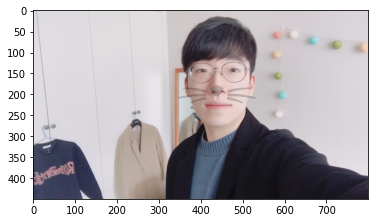

In [267]:
image, list_landmarks, dlib_rects = rotate_landmarker(img_rgb90)

# 코 중심 좌표 확인하기
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[33][0]
    y = landmark[33][1]
    w = h = dlib_rect.width()

# 스티커 불러오기
sticker_path = os.getenv('HOME') + '/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)  # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w, h))  # 얼굴 크기에 맞게 스티커를 resize한다.

# 스티커 시작 좌표 설정
refined_x = x - w // 2
refined_y = y - h // 2

# 음수 예외 처리
if refined_x < 0:
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

sticker_area = image[refined_y:refined_y + img_sticker.shape[0],
               refined_x:refined_x + img_sticker.shape[1]]

image[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x + img_sticker.shape[1]] = \
    cv2.addWeighted(sticker_area, 0.8, np.where(img_sticker == 255, sticker_area, img_sticker).astype(np.uint8), 0.2, 0)

plt.imshow(image)
plt.show()

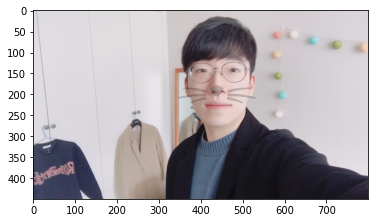

In [268]:
image, list_landmarks, dlib_rects = rotate_landmarker(img_rgb180)

# 코 중심 좌표 확인하기
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[33][0]
    y = landmark[33][1]
    w = h = dlib_rect.width()

# 스티커 불러오기
sticker_path = os.getenv('HOME') + '/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)  # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w, h))  # 얼굴 크기에 맞게 스티커를 resize한다.

# 스티커 시작 좌표 설정
refined_x = x - w // 2
refined_y = y - h // 2

# 음수 예외 처리
if refined_x < 0:
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

sticker_area = image[refined_y:refined_y + img_sticker.shape[0],
               refined_x:refined_x + img_sticker.shape[1]]

image[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x + img_sticker.shape[1]] = \
    cv2.addWeighted(sticker_area, 0.8, np.where(img_sticker == 255, sticker_area, img_sticker).astype(np.uint8), 0.2, 0)

plt.imshow(image)
plt.show()

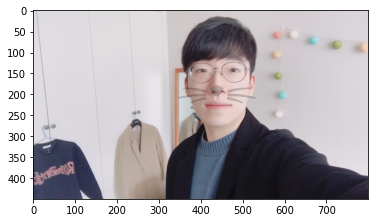

In [269]:
image, list_landmarks, dlib_rects = rotate_landmarker(img_rgb270)

# 코 중심 좌표 확인하기
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[33][0]
    y = landmark[33][1]
    w = h = dlib_rect.width()

# 스티커 불러오기
sticker_path = os.getenv('HOME') + '/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)  # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w, h))  # 얼굴 크기에 맞게 스티커를 resize한다.

# 스티커 시작 좌표 설정
refined_x = x - w // 2
refined_y = y - h // 2

# 음수 예외 처리
if refined_x < 0:
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

sticker_area = image[refined_y:refined_y + img_sticker.shape[0],
               refined_x:refined_x + img_sticker.shape[1]]

image[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x + img_sticker.shape[1]] = \
    cv2.addWeighted(sticker_area, 0.8, np.where(img_sticker == 255, sticker_area, img_sticker).astype(np.uint8), 0.2, 0)

plt.imshow(image)
plt.show()

# 함수화가 필요하다!  
다른 문제점을 고치려보니 코드가 뒤죽 박죽이 되고, 이미지를 불러올때 이미지가 섞이는 문제가 있다.  

1. 이미지 이름과, 스티커 이름을 매개 변수로 받는다  
2. 이미지와 스티커를 읽어오고,  
3. 얼굴 바운딩 박스 검출하고,  
    3-1 바운딩 박스 출력 subplot 1  
4. 랜드마크 검출  
    4-1 랜드마크 출력 subplot 2  
5. 랜드마크로 스티커 붙일 위치 정하고  
6. 실제 출력을 위한 top-left 좌표 구하고
7. 실제 적용을 한다. subplot 3

In [270]:
def sticker(img_name, sticker_name):
    fig = plt.figure(figsize=(10,10))
    row = col = 2
    # 이미지 읽어오기
    path = os.getenv('HOME') + '/aiffel/camera_sticker/images'
    image_path = os.path.join(path, img_name)
    
    img_bgr = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    
    # 바운딩 박스 검출
    img_bounding = img_rgb.copy()
    detector_hog = dlib.get_frontal_face_detector()
    dlib_rect = detector_hog(img_bounding, 1)[0]

    # 바운딩 박스 영역 출력
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    cv2.rectangle(img_bounding, (l,t), (r,b), (0, 255, 0), 2, lineType=cv2.LINE_AA)
    
    sub1 = fig.add_subplot(row,col,1)
    sub1.imshow(img_bounding)
    sub1.set_title('Bounding Box')
    
    # 랜드마크 검출 및 점 찍기
    img_landmark = img_rgb.copy()
    model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
    landmark_predictor = dlib.shape_predictor(model_path)
    
    list_landmarks = []
    
    # 랜드마크 검출
    points = landmark_predictor(img_landmark,dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)
    
    # 점 찍기
    for point in list_points:
        cv2.circle(img_landmark, point, 6, (255,255,0), -1)
    
    sub2 = fig.add_subplot(row,col, 2)
    sub2.imshow(img_landmark)
    sub2.set_title('Landmarks')
    
    # 코끝 좌표 (index = 30 )와 bounding box의 너비와 높이를 구한다
    landmark = list_landmarks[0]
    x = landmark[30][0]
    y = landmark[30][1]
    w = dlib_rect.width()
    h = dlib_rect.height()
    
    print("x : {}, y : {}".format(x, y))
    print("w : {}, h : {}".format(w, h))
    
    
    # 스티커 이미지 가지고 오기
    sticker_path = os.path.join(path, sticker_name)
    img_sticker = cv2.imread(sticker_path)
    img_sticker = cv2.resize(img_sticker, (w,h))
    
    
    # 얼굴 각도 구하기
    x1 = landmark[2][0]
    y1 = landmark[2][1]
    
    x2 = landmark[14][0]
    y2 = landmark[14][1]
    
    radians2 = math.atan2(y1-y2, x1-x2)
    degree = -(math.degrees(radians2))
    print("degree : {}".format(degree))
    
    # 스티커 이미지 회전
    rot = cv2.getRotationMatrix2D((w/2, h/2), degree, 1) 
    img_sticker = cv2.warpAffine(img_sticker, rot, (w, h), borderValue=(255,255,255))

    
    # top-left 값 구하기
    top_left_x = x - w // 2
    top_left_y = y - h // 2
    print("TL_x : {}, TL_y : {}".format(top_left_x, top_left_y))
    
    # x,y TL_x, TL_y의 좌표를 찍자
    img_point = img_rgb.copy()
    cv2.circle(img_point, (x, y), 6, (255,255,0), -1)
    cv2.circle(img_point, (top_left_x, top_left_y), 6, (255,255,0), -1)
    
    sub2 = fig.add_subplot(row,col, 3)
    sub2.imshow(img_point)
    sub2.set_title('point')
    
    # 스티커 붙이기
    sticker_width = img_sticker.shape[0]
    sticker_height = img_sticker.shape[1]
    
    sticker_area = img_rgb[top_left_y:top_left_y + sticker_width, 
                        top_left_x:top_left_x + sticker_height]

    # img_sticker를 보면서 값이 0(검은색) 이면, img_sticker로 변경, 그외 값은 sticker_area이미지로 변경
    img_rgb[top_left_y:top_left_y + sticker_width, top_left_x:top_left_x + sticker_height] = \
        np.where(img_sticker == 255, sticker_area, img_sticker).astype(np.uint8)
    
    sub2 = fig.add_subplot(row,col, 4)
    sub2.imshow(img_rgb)
    sub2.set_title('result')
    
    plt.show()

x : 437, y : 182
w : 187, h : 187
degree : -180.0
TL_x : 344, TL_y : 89


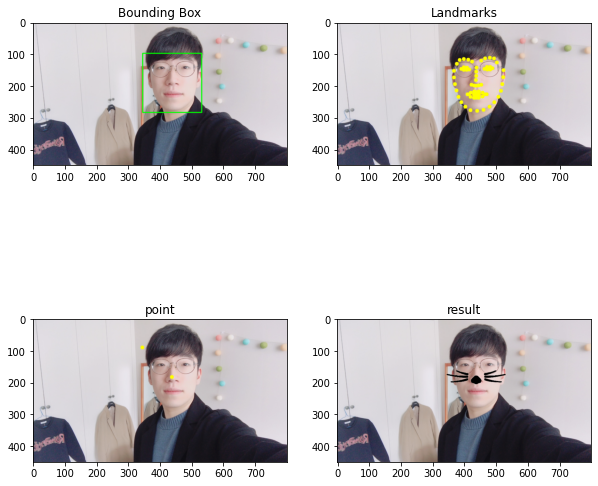

2.0842137336730957 sec


In [227]:
start = time.time()
sticker('image.png', 'cat-whiskers.png')
end = time.time()

print("{} sec".format(end - start))

## 다른 사진들에서도 잘 작동을 한다.

x : 110, y : 115
w : 130, h : 130
degree : -178.00790642703356
TL_x : 45, TL_y : 50


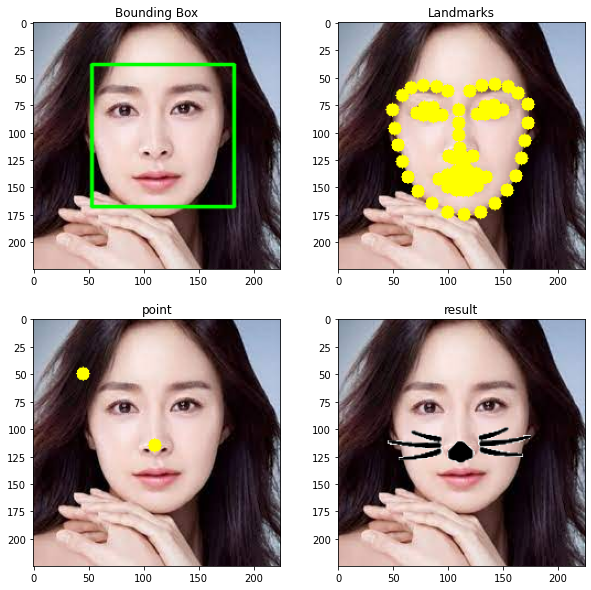

1.8048982620239258 sec


In [228]:
start = time.time()
sticker('image1.jpg', 'cat-whiskers.png')
end = time.time()

print("{} sec".format(end - start))

x : 249, y : 153
w : 224, h : 224
degree : -171.01236270179152
TL_x : 137, TL_y : 41


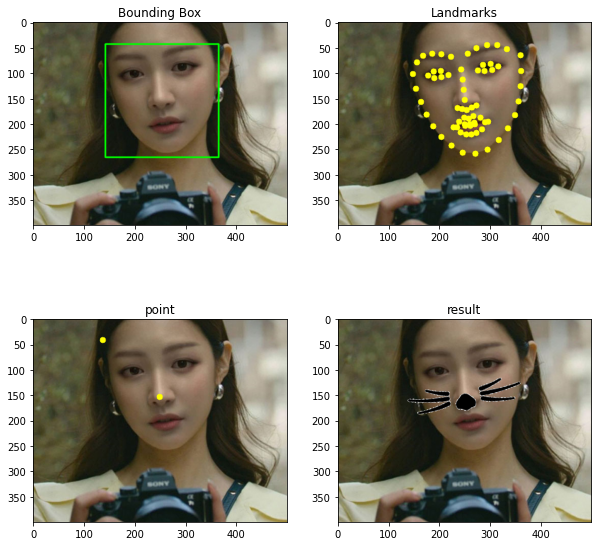

1.9548189640045166 sec


In [229]:
start = time.time()
sticker('image2.jpg', 'cat-whiskers.png')
end = time.time()

print("{} sec".format(end - start))

x : 317, y : 81
w : 76, h : 75
degree : -175.16958004171005
TL_x : 279, TL_y : 44


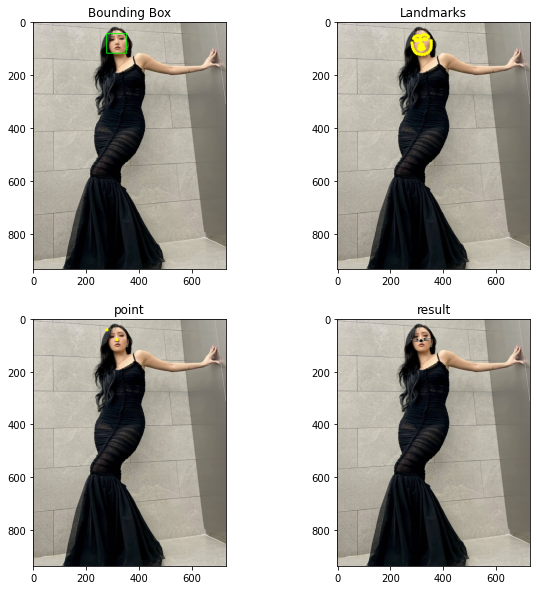

2.4396049976348877 sec


In [230]:
start = time.time()
sticker('image3.jpg', 'cat-whiskers.png')
end = time.time()

print("{} sec".format(end - start))

## 고개를 좌우로 갸우뚱 한 사진에 대하여

### 얼굴과 스티커 사진의 이미지가 어울리지 않는다.
스티커도 얼굴 각도에 맞게 돌아 갔으면 좋겠다!

x : 408, y : 234
w : 223, h : 224
TL_x : 297, TL_y : 122


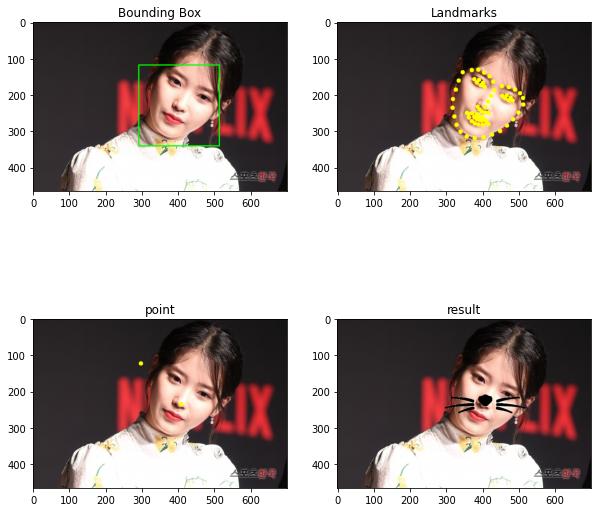

2.0341429710388184 sec


In [237]:
start = time.time()
sticker('right.jpg', 'cat-whiskers.png')
end = time.time()

print("{} sec".format(end - start))

## 좌우 광대 랜드마크를 기준으로 각도를 구한뒤 스티커를 돌려서 붙였다. 

x : 408, y : 234
w : 223, h : 224
degree : 152.57125877832243
TL_x : 297, TL_y : 122


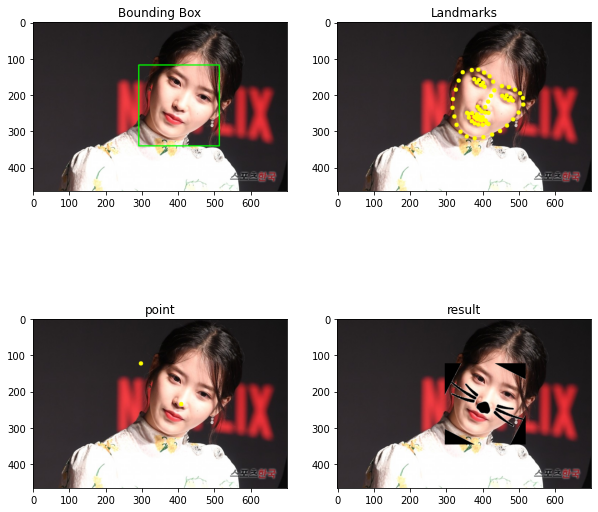

In [233]:
sticker('right.jpg', 'cat-whiskers.png')

### 하지만 돌린 범위만큼 사진의 공백이 생겨 버렸다.
warpAffine()의 파라미터중 borderValue라는 파라미터가 있는데, 이는 사진들 돌렸을때 나타나는 공백의 색을 지정할수 있는 파라미터이다.  
현재 우리가 사용하는 스티커의 배경값은 하얀색이므로 이에 맞춰서 함수를 수정해주었다.  
img_sticker = cv2.warpAffine(img_sticker, rot, (w, h))에서  
img_sticker = cv2.warpAffine(img_sticker, rot, (w, h), borderValue=(255,255,255))

x : 408, y : 234
w : 223, h : 224
degree : 152.57125877832243
TL_x : 297, TL_y : 122


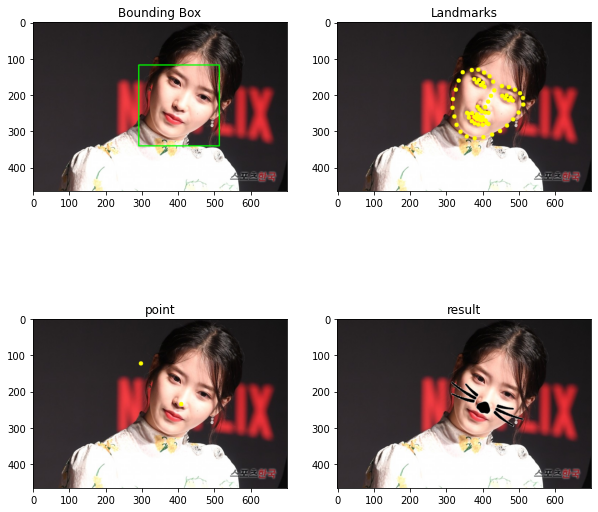

1.9926414489746094 sec


In [239]:
start = time.time()
sticker('right.jpg', 'cat-whiskers.png')
end = time.time()

print("{} sec".format(end - start))

x : 316, y : 168
w : 268, h : 268
degree : -152.92339295633496
TL_x : 182, TL_y : 34


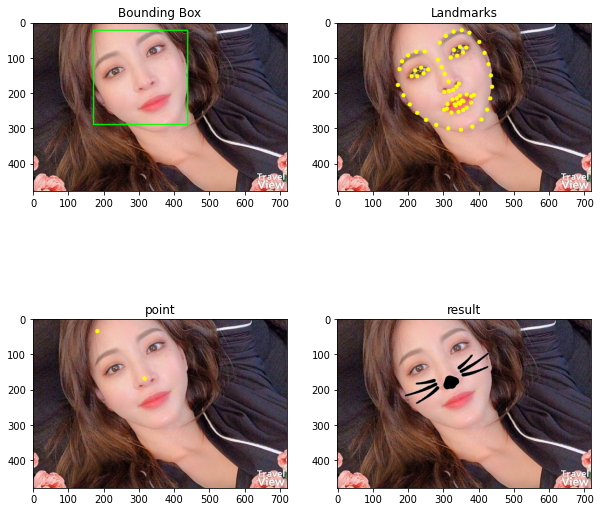

2.0320048332214355 sec


In [240]:
start = time.time()
sticker('left.jpg', 'cat-whiskers.png')
end = time.time()

print("{} sec".format(end - start))

### 회고
이번 Exploration을 하면서 코드의 재사용에 대해서 한번더 생각할 수 있는 계기가 되었다.  
코드를 여러번 사용 할것 같으면 함수를 만들어서 재사용을 한다면 좀더 생산성이 높아진다는것을 깨달았다.  
고양이 스티커를 붙이는데 실행속도가 약 1.8s ~ 2.0s 사이의 시간을 보여주었다.  
실시간으로 스티커를 붙여주는데는 조금 느릴지라도, 사진을 가지고 붙여주는건 이해 가능한 속도라고 생각한다.  
다음으로 정확도는 스티커를 어느 기준으로 붙일 것인가에 대해 생각하면 좋은 정도라고 생각한다.  

마지막으로 스티커를 회전할때 getRotationMatrix2D 함수를 사용했는데, 정확한 이해 없이 여러번 돌려보면서 각도를 맞추었다.  
이번 Exploration이 끝나고 사진의 각도에 대한 공부를 좀더 해보면 좋을듯하다.  

추가로 해보고 싶은 사항은 좌우로 고개를 돌렸을때, 좌우 얼굴의 면적에 따라서 스티커의 면적도 달라지는걸 해보면 좋을듯 하다.
